In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression,Ridge,Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('Real_estate_valuation.xlsx')

In [3]:
df.columns

Index(['No', 'X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

In [4]:
df.columns = ['No', 'transaction_date', 'house_age',
       'distance_MRT',
       'num_convenience_stores', 'latitude', 'longitude',
       'price']

In [5]:
df.columns

Index(['No', 'transaction_date', 'house_age', 'distance_MRT',
       'num_convenience_stores', 'latitude', 'longitude', 'price'],
      dtype='object')

In [6]:
df.head()

,No,transaction_date,house_age,distance_MRT,num_convenience_stores,latitude,longitude,price
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [7]:
df = df.drop('No',axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
transaction_date          414 non-null float64
house_age                 414 non-null float64
distance_MRT              414 non-null float64
num_convenience_stores    414 non-null int64
latitude                  414 non-null float64
longitude                 414 non-null float64
price                     414 non-null float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


In [9]:
df['transaction_date'] = df['transaction_date'].astype(str)

In [10]:
X = df['transaction_date'].str.split('.',expand=True)

In [11]:
df['transaction_date'] = X[0]

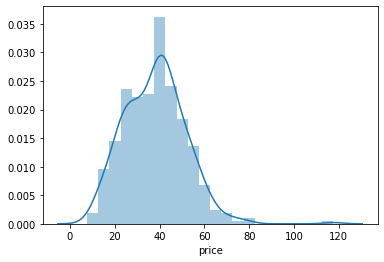

In [12]:
sns.distplot(df.price)

In [13]:
## Outliers for Y (IQR method)
q1,q2,q3 = df['price'].quantile([0.25,0.50,0.75])
print(q1,q2,q3)
upper_v = q3+(1.5*(q3-q1))
lower_v = q1-(1.5*(q3-q1))
print(lower_v,upper_v)

27.7 38.45 46.6
-0.6500000000000021 74.95


In [14]:
df['price'].describe()

count    414.000000
mean      37.980193
std       13.606488
min        7.600000
25%       27.700000
50%       38.450000
75%       46.600000
max      117.500000
Name: price, dtype: float64

In [15]:
df = df[~(df['price']>74.95)]
df.shape

(411, 7)

In [16]:
df.corr()

,house_age,distance_MRT,num_convenience_stores,latitude,longitude,price
house_age,1.000000,0.030167,0.035385,0.052285,-0.053527,-0.242852
distance_MRT,0.030167,1.000000,-0.604710,-0.590426,-0.806768,-0.701349
num_convenience_stores,0.035385,-0.604710,1.000000,0.446079,0.448211,0.605853
latitude,0.052285,-0.590426,0.446079,1.000000,0.412657,0.571849
longitude,-0.053527,-0.806768,0.448211,0.412657,1.000000,0.554585
price,-0.242852,-0.701349,0.605853,0.571849,0.554585,1.000000


In [17]:
df.isna().sum()

transaction_date          0
house_age                 0
distance_MRT              0
num_convenience_stores    0
latitude                  0
longitude                 0
price                     0
dtype: int64

In [18]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'],format='%Y')
df['transaction_date'] = df['transaction_date'].dt.year

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411 entries, 0 to 413
Data columns (total 7 columns):
transaction_date          411 non-null int64
house_age                 411 non-null float64
distance_MRT              411 non-null float64
num_convenience_stores    411 non-null int64
latitude                  411 non-null float64
longitude                 411 non-null float64
price                     411 non-null float64
dtypes: float64(5), int64(2)
memory usage: 25.7 KB


In [20]:
df.head()

,transaction_date,house_age,distance_MRT,num_convenience_stores,latitude,longitude,price
0,2012,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012,5.0,390.56840,5,24.97937,121.54245,43.1


In [22]:
df['num_convenience_stores'].value_counts()

5     67
0     67
3     46
1     45
6     37
7     31
4     31
8     30
2     24
9     23
10    10
Name: num_convenience_stores, dtype: int64

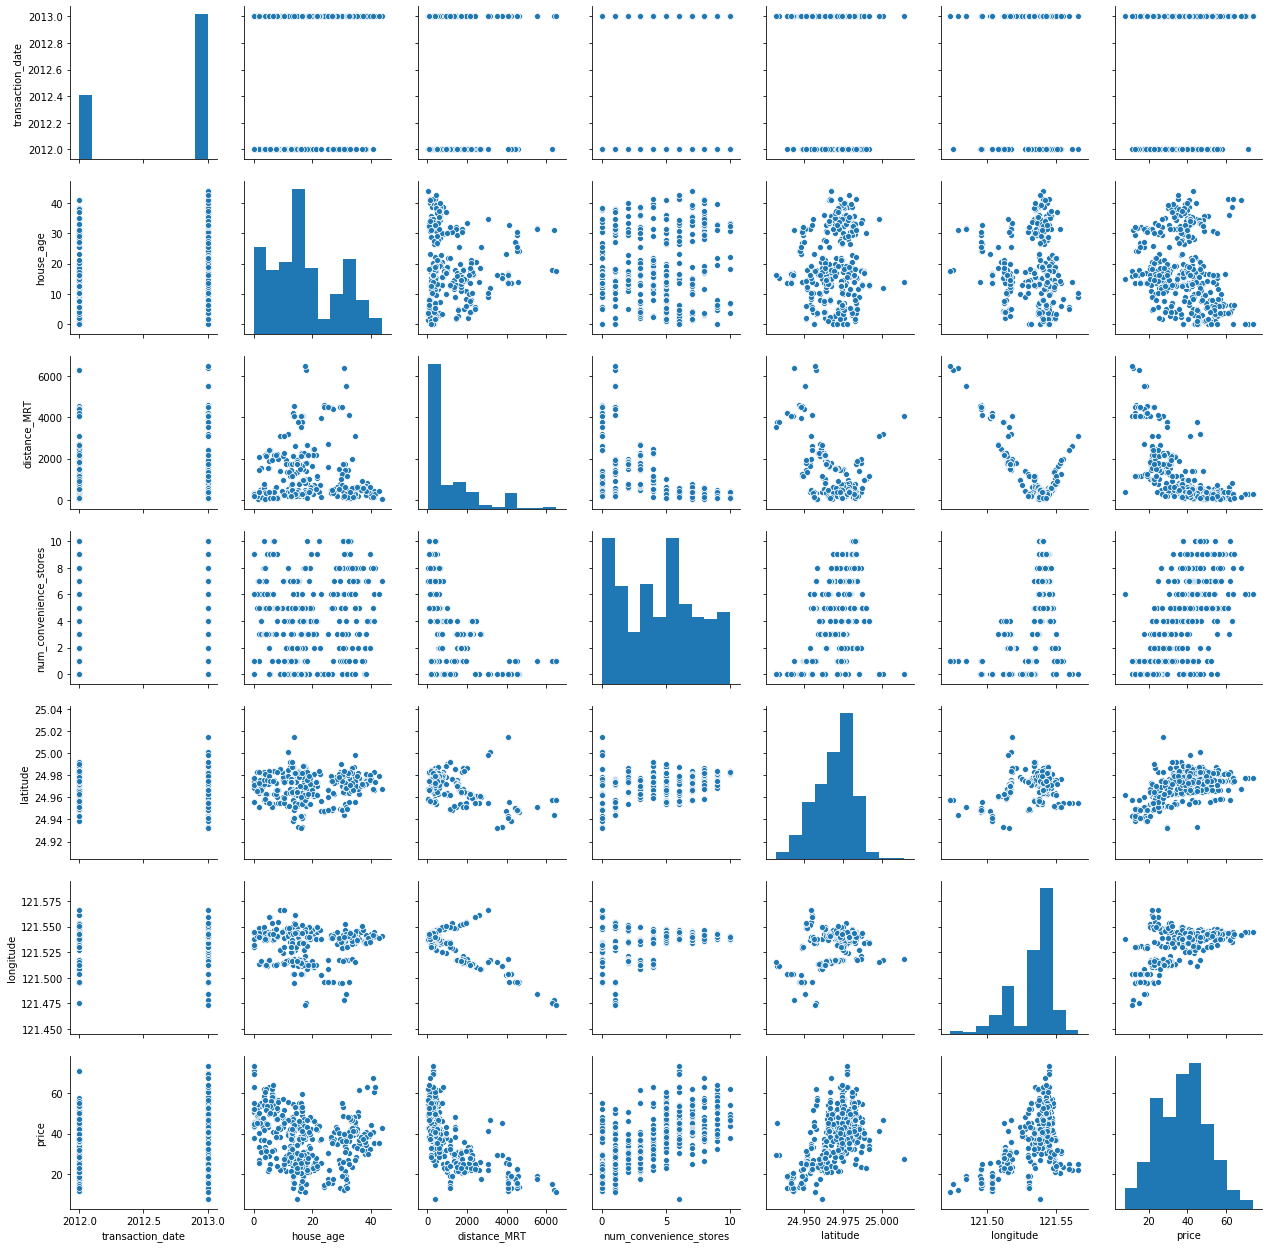

In [23]:
sns.pairplot(df)

In [24]:
dum = pd.get_dummies(df['num_convenience_stores'], prefix = 'ncs')
df = pd.concat([df,dum], axis=1)
df.shape

(411, 18)

In [25]:
df = df.drop('num_convenience_stores',axis=1)

In [26]:
df.head()

,transaction_date,house_age,distance_MRT,latitude,longitude,price,ncs_0,ncs_1,ncs_2,ncs_3,ncs_4,ncs_5,ncs_6,ncs_7,ncs_8,ncs_9,ncs_10
0,2012,32.0,84.87882,24.98298,121.54024,37.9,0,0,0,0,0,0,0,0,0,0,1
1,2012,19.5,306.59470,24.98034,121.53951,42.2,0,0,0,0,0,0,0,0,0,1,0
2,2013,13.3,561.98450,24.98746,121.54391,47.3,0,0,0,0,0,1,0,0,0,0,0
3,2013,13.3,561.98450,24.98746,121.54391,54.8,0,0,0,0,0,1,0,0,0,0,0
4,2012,5.0,390.56840,24.97937,121.54245,43.1,0,0,0,0,0,1,0,0,0,0,0


In [27]:
dum = pd.get_dummies(df['transaction_date'], prefix = 'td')
df = pd.concat([df,dum], axis=1)
df.shape

(411, 19)

In [28]:
df = df.drop('transaction_date',axis=1)

### Assumptions Linear Reg

In [29]:
X = df.drop('price',axis=1)
y = df['price']

In [30]:
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm

X_constant = sm.add_constant(X)
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     53.90
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           1.07e-85
Time:                        14:56:55   Log-Likelihood:                -1400.6
No. Observations:                 411   AIC:                             2833.
Df Residuals:                     395   BIC:                             2897.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          887.5185   3448.923      0.257      0.797   -5893.022    7668.059
house_age       -0.2843      0.034     -8.308      0.000      -0.352      -0.217
distance_MRT    -0.0042      0.001     -6.723      0.000      -0.005      -0.003
latitude       284.7896     39.487      7.212      0.000     207.159     362.420
longitude      -69.7380     43.873     -1.590      0.113    -155.992      16.516
ncs_0           77.0664    313.663      0.246      0.806    -539.591     693.724
ncs_1           77.1287    313.653      0.246      0.806    -539.509     693.766
ncs_2           74.2308    313.475      0.237      0.813    -542.058     690.520
ncs_3           73.8226    313.209      0.236      0.814    -541.942     689.587
ncs_4           77.6181    313.594      0.248      0.805    -538.905     694.141
ncs_5           82.5245    313.594      0.263      0.793    -533.998     699.047
ncs_6           85.2628    313.553      0.272      0.786    -531.178     701.704
ncs_7           83.4425    313.527      0.266      0.790    -532.948     699.833
ncs_8           85.7891    313.593      0.274      0.785    -530.731     702.309
ncs_9           85.6763    313.565      0.273      0.785    -530.789     702.142
ncs_10          84.9568    313.530      0.271      0.787    -531.439     701.353
td_2012        442.4755   1724.431      0.257      0.798   -2947.735    3832.686
td_2013        445.0430   1724.492      0.258      0.796   -2945.287    3835.373
==============================================================================
Omnibus:                       57.915   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              227.680
Skew:                           0.548   Prob(JB):                     3.63e-50
Kurtosis:                       6.478   Cond. No.                     3.41e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.84e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

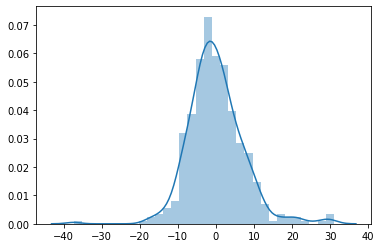

In [31]:
sns.distplot(lin_reg.resid)

In [32]:
import statsmodels.api as sm
sm.stats.diagnostic.linear_rainbow(res=lin_reg, frac=0.5)

(0.8442930170080771, 0.8828759601430434)

In [33]:
lin_reg.resid.mean()

-2.21335445240825e-11

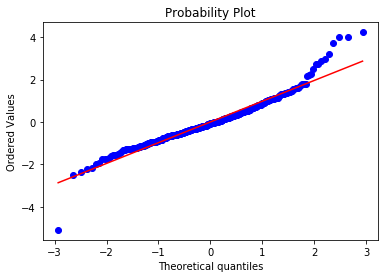

In [34]:
import scipy.stats as stats
import pylab
from statsmodels.graphics.gofplots import ProbPlot
st_residual = lin_reg.get_influence().resid_studentized_internal
stats.probplot(st_residual, dist="norm", plot = pylab)
plt.show()

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X1 = df.drop(['ncs_0','td_2012'],axis=1)
X1_constant = sm.add_constant(X1)
vif = [variance_inflation_factor(X1_constant.values, i) for i in range(X1_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X1.columns).T

,house_age,distance_MRT,latitude,longitude,price,ncs_1,ncs_2,ncs_3,ncs_4,ncs_5,ncs_6,ncs_7,ncs_8,ncs_9,ncs_10,td_2013
vif,1.308729,5.15854,2.017447,3.387264,3.046728,1.543909,1.445357,1.803546,1.642088,2.450761,1.945467,1.783937,1.863337,1.676413,1.342746,1.045322


In [36]:
X1.shape

(411, 16)

In [37]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

X1_const = sm.add_constant(X1)
lin_reg = sm.OLS(y,X1_const).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.106e+24
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        14:56:57   Log-Likelihood:                 9358.7
No. Observations:                 411   AIC:                        -1.868e+04
Df Residuals:                     394   BIC:                        -1.862e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.276e-12   2.35e-08     -0.000      1.000   -4.62e-08    4.62e-08
house_age     9.298e-16   1.59e-13      0.006      0.995   -3.11e-13    3.13e-13
distance_MRT  -7.66e-17   2.83e-15     -0.027      0.978   -5.64e-15    5.49e-15
latitude      2.842e-14    1.8e-10      0.000      1.000   -3.53e-10    3.53e-10
longitude    -2.025e-13   1.88e-10     -0.001      0.999   -3.71e-10     3.7e-10
price            1.0000   2.15e-13   4.64e+12      0.000       1.000       1.000
ncs_1        -5.329e-15   6.26e-12     -0.001      0.999   -1.23e-11    1.23e-11
ncs_2        -5.995e-15   8.07e-12     -0.001      0.999   -1.59e-11    1.59e-11
ncs_3         6.661e-15    6.7e-12      0.001      0.999   -1.32e-11    1.32e-11
ncs_4         -9.77e-15   7.63e-12     -0.001      0.999    -1.5e-11     1.5e-11
ncs_5        -2.665e-15   6.67e-12     -0.000      1.000   -1.31e-11    1.31e-11
ncs_6        -8.216e-15   7.67e-12     -0.001      0.999   -1.51e-11    1.51e-11
ncs_7        -6.661e-15   7.96e-12     -0.001      0.999   -1.57e-11    1.56e-11
ncs_8        -3.109e-15   8.26e-12     -0.000      1.000   -1.62e-11    1.62e-11
ncs_9         1.776e-15   8.86e-12      0.000      1.000   -1.74e-11    1.74e-11
ncs_10       -4.574e-14   1.18e-11     -0.004      0.997   -2.33e-11    2.32e-11
td_2013       1.721e-15   3.49e-12      0.000      1.000   -6.86e-12    6.86e-12
==============================================================================
Omnibus:                      143.051   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              347.775
Skew:                           1.775   Prob(JB):                     3.03e-76
Kurtosis:                       5.777   Cond. No.                     2.49e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
X1 = X1.drop('price',axis=1)

In [39]:
cols = list(X1.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X1[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['house_age', 'distance_MRT', 'latitude', 'ncs_5', 'ncs_6', 'ncs_7', 'ncs_8', 'ncs_9', 'ncs_10', 'td_2013']


In [40]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
X2 =X1[['house_age', 'distance_MRT', 'latitude', 'ncs_5', 'ncs_6', 'ncs_7', 'ncs_8', 'ncs_9', 'ncs_10', 'td_2013']]
X2_const = sm.add_constant(X2)
lin_reg = sm.OLS(y,X2_const).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     79.27
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           1.76e-88
Time:                        14:57:06   Log-Likelihood:                -1405.0
No. Observations:                 411   AIC:                             2832.
Df Residuals:                     400   BIC:                             2876.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6997.5650    938.128     -7.459      0.000   -8841.842   -5153.288
house_age       -0.2822      0.034     -8.229      0.000      -0.350      -0.215
distance_MRT    -0.0035      0.000     -8.172      0.000      -0.004      -0.003
latitude       281.8867     37.564      7.504      0.000     208.040     355.733
ncs_5            6.3510      1.176      5.401      0.000       4.039       8.663
ncs_6            9.1090      1.450      6.282      0.000       6.258      11.960
ncs_7            7.3262      1.548      4.732      0.000       4.283      10.370
ncs_8            9.6272      1.590      6.053      0.000       6.500      12.754
ncs_9            9.5777      1.752      5.468      0.000       6.134      13.021
ncs_10           9.0631      2.510      3.611      0.000       4.128      13.998
td_2013          2.3709      0.803      2.951      0.003       0.791       3.950
==============================================================================
Omnibus:                       54.399   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.955
Skew:                           0.548   Prob(JB):                     9.31e-42
Kurtosis:                       6.135   Cond. No.                     4.24e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.24e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
df.corr()

,house_age,distance_MRT,latitude,longitude,price,ncs_0,ncs_1,ncs_2,ncs_3,ncs_4,ncs_5,ncs_6,ncs_7,ncs_8,ncs_9,ncs_10,td_2012,td_2013
house_age,1.000000,0.030167,0.052285,-0.053527,-0.242852,0.002028,-0.009723,0.056329,-0.009657,0.026398,-0.135103,-0.082484,0.042159,0.239045,-0.103512,0.059334,-0.045278,0.045278
distance_MRT,0.030167,1.000000,-0.590426,-0.806768,-0.701349,0.471523,0.187984,0.052765,0.174247,-0.019338,-0.246989,-0.195192,-0.182390,-0.169873,-0.171001,-0.105879,-0.019766,0.019766
latitude,0.052285,-0.590426,1.000000,0.412657,0.571849,-0.403602,-0.201481,0.072111,-0.052005,0.182376,0.145164,0.040963,0.046367,0.117338,0.123199,0.174537,-0.006153,0.006153
longitude,-0.053527,-0.806768,0.412657,1.000000,0.554585,-0.281966,-0.083826,-0.090174,-0.329837,0.003015,0.233370,0.175149,0.146702,0.147330,0.140401,0.058382,-0.011765,0.011765
price,-0.242852,-0.701349,0.571849,0.554585,1.000000,-0.385099,-0.210487,-0.120649,-0.224199,-0.002621,0.247028,0.230845,0.140133,0.156338,0.226102,0.134209,-0.067072,0.067072
ncs_0,0.002028,0.471523,-0.403602,-0.281966,-0.385099,1.000000,-0.154748,-0.109903,-0.156672,-0.126051,-0.194767,-0.138811,-0.126051,-0.123839,-0.107450,-0.069692,-0.022003,0.022003
ncs_1,-0.009723,0.187984,-0.201481,-0.083826,-0.210487,-0.154748,1.000000,-0.087320,-0.124480,-0.100151,-0.154748,-0.110289,-0.100151,-0.098393,-0.085372,-0.055372,0.071054,-0.071054
ncs_2,0.056329,0.052765,0.072111,-0.090174,-0.120649,-0.109903,-0.087320,1.000000,-0.088406,-0.071128,-0.109903,-0.078328,-0.071128,-0.069879,-0.060631,-0.039326,-0.008049,0.008049
ncs_3,-0.009657,0.174247,-0.052005,-0.329837,-0.224199,-0.156672,-0.124480,-0.088406,1.000000,-0.101396,-0.156672,-0.111660,-0.101396,-0.099616,-0.086433,-0.056061,-0.051925,0.051925
ncs_4,0.026398,-0.019338,0.182376,0.003015,-0.002621,-0.126051,-0.100151,-0.071128,-0.101396,1.000000,-0.126051,-0.089837,-0.081579,-0.080147,-0.069540,-0.045104,0.009919,-0.009919


In [42]:
X2_const = sm.add_constant(X2)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X2_const.values, i) for i in range(X2_const.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X2.columns).T

,house_age,distance_MRT,latitude,ncs_5,ncs_6,ncs_7,ncs_8,ncs_9,ncs_10,td_2013
vif,1.109031,2.135188,1.598852,1.383654,1.263183,1.225603,1.255139,1.188543,1.096826,1.006288


In [43]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
clf = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X2,y, test_size = 0.3, random_state = 0)


# Build step forward feature selection
sfs1 = sfs(clf,k_features = 10,forward=True,
           floating=False, scoring='r2',
           verbose=2,
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished

[2019-12-09 14:57:14] Features: 1/10 -- score: 0.4953397944745975[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished

[2019-12-09 14:57:14] Features: 2/10 -- score: 0.5337836471920856[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished

[2019-12-09 14:57:14] Features: 3/10 -- score: 0.5683664143978899[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [44]:
sfs1.fit(X_test,y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished

[2019-12-09 14:57:17] Features: 1/10 -- score: 0.4393218638179782[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished

[2019-12-09 14:57:17] Features: 2/10 -- score: 0.49629458831594775[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished

[2019-12-09 14:57:18] Features: 3/10 -- score: 0.5618239288582346[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=LinearRegression(copy_X=True,
                                                     fit_intercept=True,
                                                     n_jobs=None,
                                                     normalize=False),
                          floating=False, forward=True, k_features=10, n_jobs=1,
                          pre_dispatch='2*n_jobs', scoring='r2', verbose=2)

In [45]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

0.9899113184152386
0.6687230293991947


In [46]:
from sklearn.linear_model import Ridge

In [47]:
rr = Ridge(alpha=0.01) 
# restricted and in this case linear and ridge regression resembles
rr.fit(X_train, y_train)
Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)
print("ridge regression train score low alpha:", Ridge_train_score)
print("ridge regression test score low alpha:", Ridge_test_score)

ridge regression train score low alpha: 0.6691630095817717
ridge regression test score low alpha: 0.6151540055826925


In [48]:
##########################################################################################################################

In [141]:
df = pd.read_excel('Real_estate_valuation.xlsx')

In [142]:
df.columns

Index(['No', 'X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

In [143]:
df1 = df.drop(['No', 'X1 transaction date'],axis=1)

In [144]:
df1 = df1[~(df1['Y house price of unit area']>74.95)]
df1.columns

Index(['X2 house age', 'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

In [145]:
X = df1.drop('Y house price of unit area',axis=1)
y = df1['Y house price of unit area'] 

In [113]:
from sklearn import preprocessing
df_nor=preprocessing.normalize(X)
df_nor=pd.DataFrame(df_nor)
df_nor
df_nor.columns=X.columns
df_nor

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores
0,0.350646,0.930075,0.109577
1,0.063446,0.997556,0.029283
2,0.023659,0.999681,0.008894
3,0.023659,0.999681,0.008894
4,0.012800,0.999836,0.012800
...,...,...,...
406,0.003356,0.999994,0.000000
407,0.061488,0.993204,0.098820
408,0.048022,0.998686,0.017881
409,0.076966,0.995901,0.047510


In [114]:
#X = df_nor.drop('Y house price of unit area',axis=1)
#y = df_nor['Y house price of unit area']

In [134]:
from sklearn.metrics import mean_squared_error
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)
model = LinearRegression()
model.fit(X_train,y_train)
print(model.score(X_train,y_train),model.score(X_test,y_test))

0.5942026532009356 0.6199972641413605


In [116]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf',gamma='scale',C=0.5)
svr.fit(X_train,y_train)
print(svr.score(X_train,y_train),svr.score(X_test,y_test))

0.5326255398906734 0.5353361081268377


In [117]:
y_pred = svr.predict(X_test)

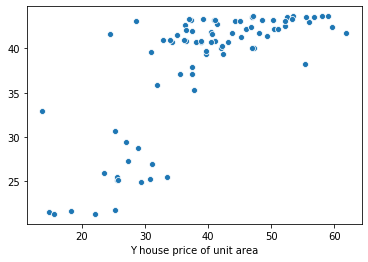

In [118]:
sns.scatterplot(y_test,y_pred)

In [136]:
np.sqrt(mean_squared_error(y_test,y_pred))

7.449834039921076

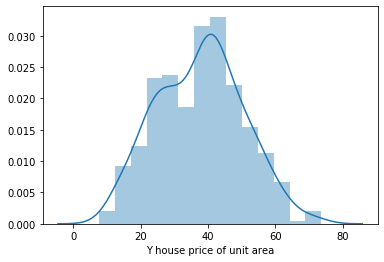

In [137]:
sns.distplot(y)

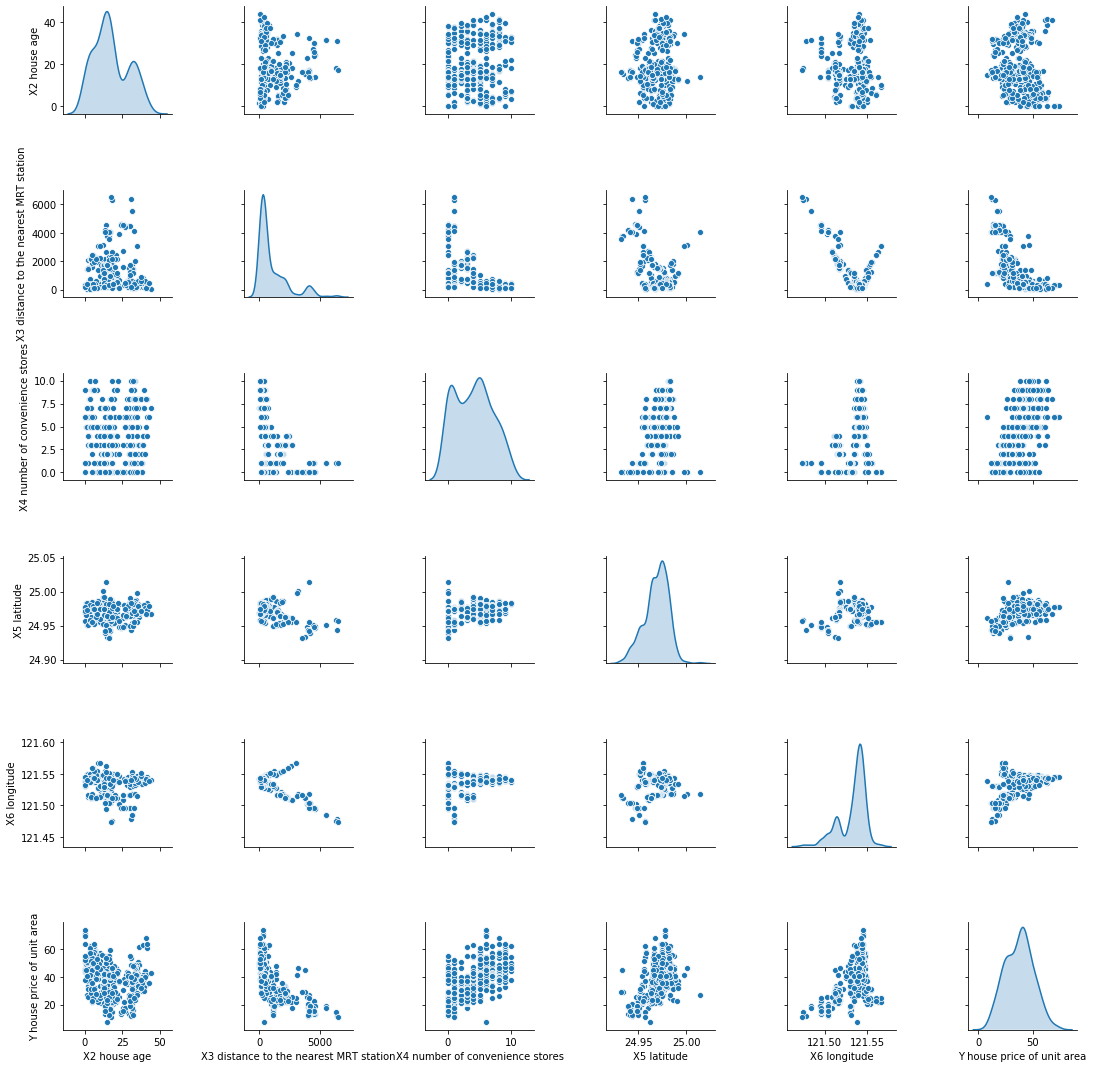

In [164]:
sns.pairplot(df1,diag_kind='kde')

In [152]:
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)
ss = StandardScaler()
xtrain = ss.fit_transform(X_train)
xtest = ss.transform(X_test)
xtrain = pd.DataFrame(xtrain,columns = X.columns)
xtest = pd.DataFrame(xtest,columns = X.columns)

In [153]:
xtrain.head()

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,-0.450096,0.026261,-0.022824,1.814684,0.084343
1,-0.643516,1.548989,-1.383987,-1.178348,2.123007
2,-0.072050,2.325278,-1.383987,-2.115081,-1.917676
3,-0.283052,-0.740397,-1.043697,0.359246,-0.222325
4,-0.414929,-0.486864,0.317466,-0.328604,0.265000


In [166]:
model = LinearRegression()
model.fit(xtrain,y_train)
print(model.score(xtrain,y_train),model.score(xtest,y_test))

0.6163936690552784 0.6972866025329983


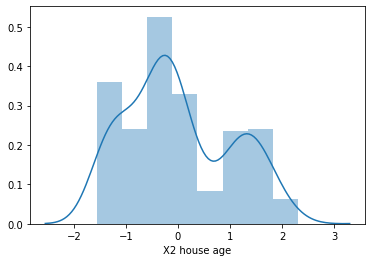

In [155]:
sns.distplot(xtrain['X2 house age'])

In [169]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.92)
pxtrain = pca.fit_transform(xtrain)
pxtest = pca.transform(xtest)
pxtrain = pd.DataFrame(pxtrain)
pxtest = pd.DataFrame(pxtest)

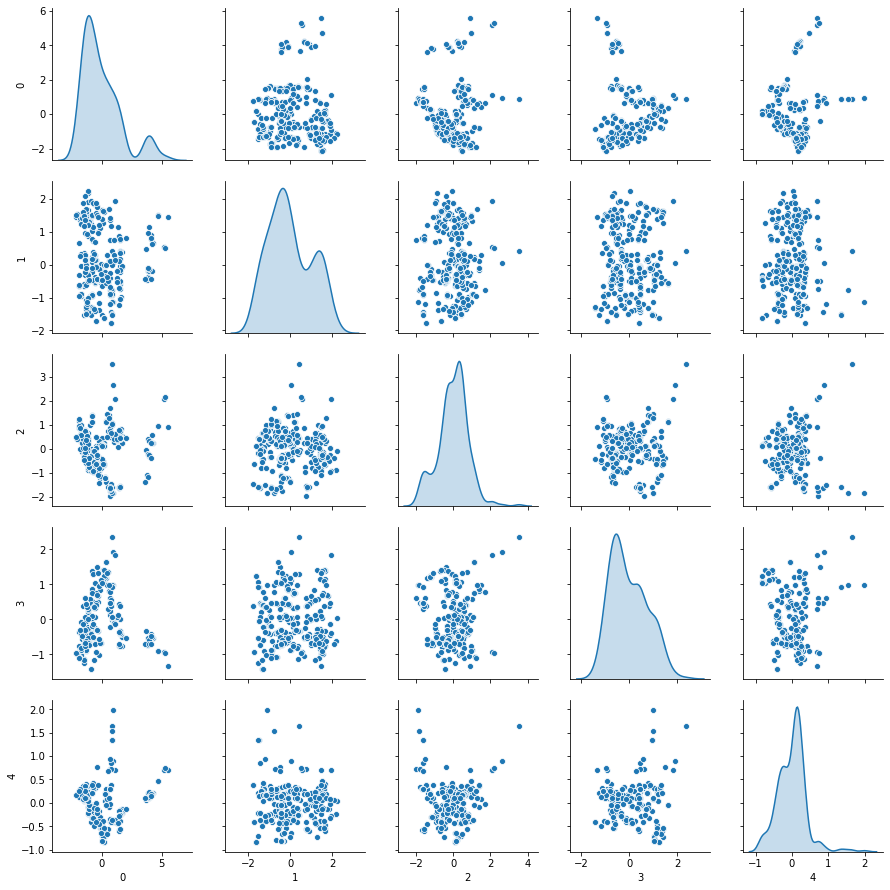

In [168]:
sns.pairplot(pxtrain,diag_kind='kde')

In [170]:
model = LinearRegression()
model.fit(pxtrain,y_train)
print(model.score(pxtrain,y_train),model.score(pxtest,y_test))

0.6121901795611919 0.6878156274576396
